In [1]:
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
import datetime as dt
import pandas as pd

In [2]:
# nwp_path = "gs://solar-pv-nowcasting-data/NWP/UK_Met_Office/UKV_intermediate_version_4.zarr/"
nwp_path = "gs://solar-pv-nowcasting-data/NWP/UK_Met_Office/UKV_intermediate_version_4/UKV_intermediate_version_3.zarr"
gsp_path = "gs://solar-pv-nowcasting-data/PV/GSP/v5/pv_gsp.zarr"

gsp = xr.open_zarr(gsp_path)
nwp = xr.open_zarr(nwp_path)
nwp = nwp.chunk({"step": 1, "variable": 1, "init_time": 50})

evaluation_timeseries = gsp.coords["datetime_gmt"].where(
        (gsp["datetime_gmt"] >= nwp.coords["init_time"].values[0]) & (gsp["datetime_gmt"] <= nwp.coords["init_time"].values[-1]), 
        drop=True).values

gsp = gsp.sel(datetime_gmt = evaluation_timeseries, gsp_id=0)

In [3]:
from gradboost_pv.models.basic import build_datasets_from_local, load_local_preprocessed_slice
from gradboost_pv.models.experiment import run_experiment, plot_feature_importances, plot_loss_metrics

results = dict()

for _step in range(0, 36):
    step_slice = load_local_preprocessed_slice(_step)
    step_slice = step_slice.reshape(step_slice.shape[1], step_slice.shape[2])
    X, y = build_datasets_from_local(step_slice, gsp, nwp.coords["step"].values[_step])
    output = run_experiment(X, y, save_errors_locally=True, errors_local_save_file="/home/tom/local_data/basic_model_errors.pkl")
    
    results[_step] = output
    print(f"Completed run for step {_step}")
    

/home/tom/dev/gradboost_pv/gradboost_pv/models/common.py:100: RuntimeWarning: invalid value encountered in multiply
  betas = np.nan * np.empty(len(y))


Completed run for step 0
Completed run for step 1
Completed run for step 2
Completed run for step 3
Completed run for step 4
Completed run for step 5
Completed run for step 6
Completed run for step 7
Completed run for step 8
Completed run for step 9


/home/tom/dev/gradboost_pv/gradboost_pv/models/common.py:100: RuntimeWarning: invalid value encountered in multiply
  betas = np.nan * np.empty(len(y))


Completed run for step 10
Completed run for step 11
Completed run for step 12
Completed run for step 13
Completed run for step 14
Completed run for step 15
Completed run for step 16
Completed run for step 17
Completed run for step 18
Completed run for step 19
Completed run for step 20
Completed run for step 21
Completed run for step 22
Completed run for step 23
Completed run for step 24
Completed run for step 25
Completed run for step 26
Completed run for step 27
Completed run for step 28
Completed run for step 29
Completed run for step 30
Completed run for step 31
Completed run for step 32
Completed run for step 33
Completed run for step 34
Completed run for step 35


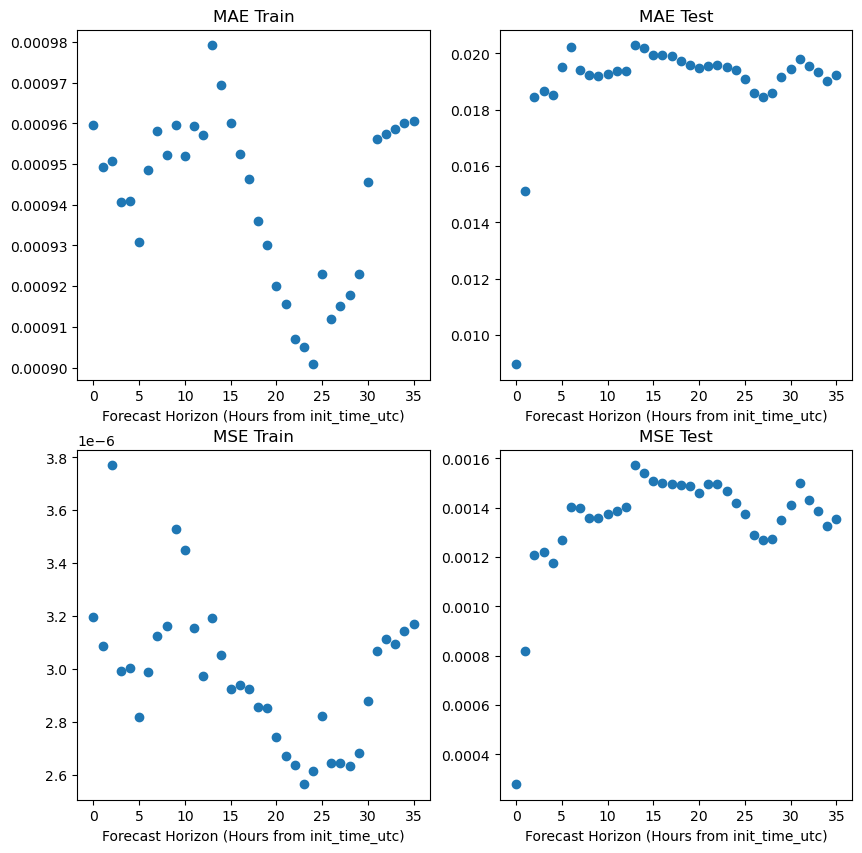

In [4]:
plot_loss_metrics(results)

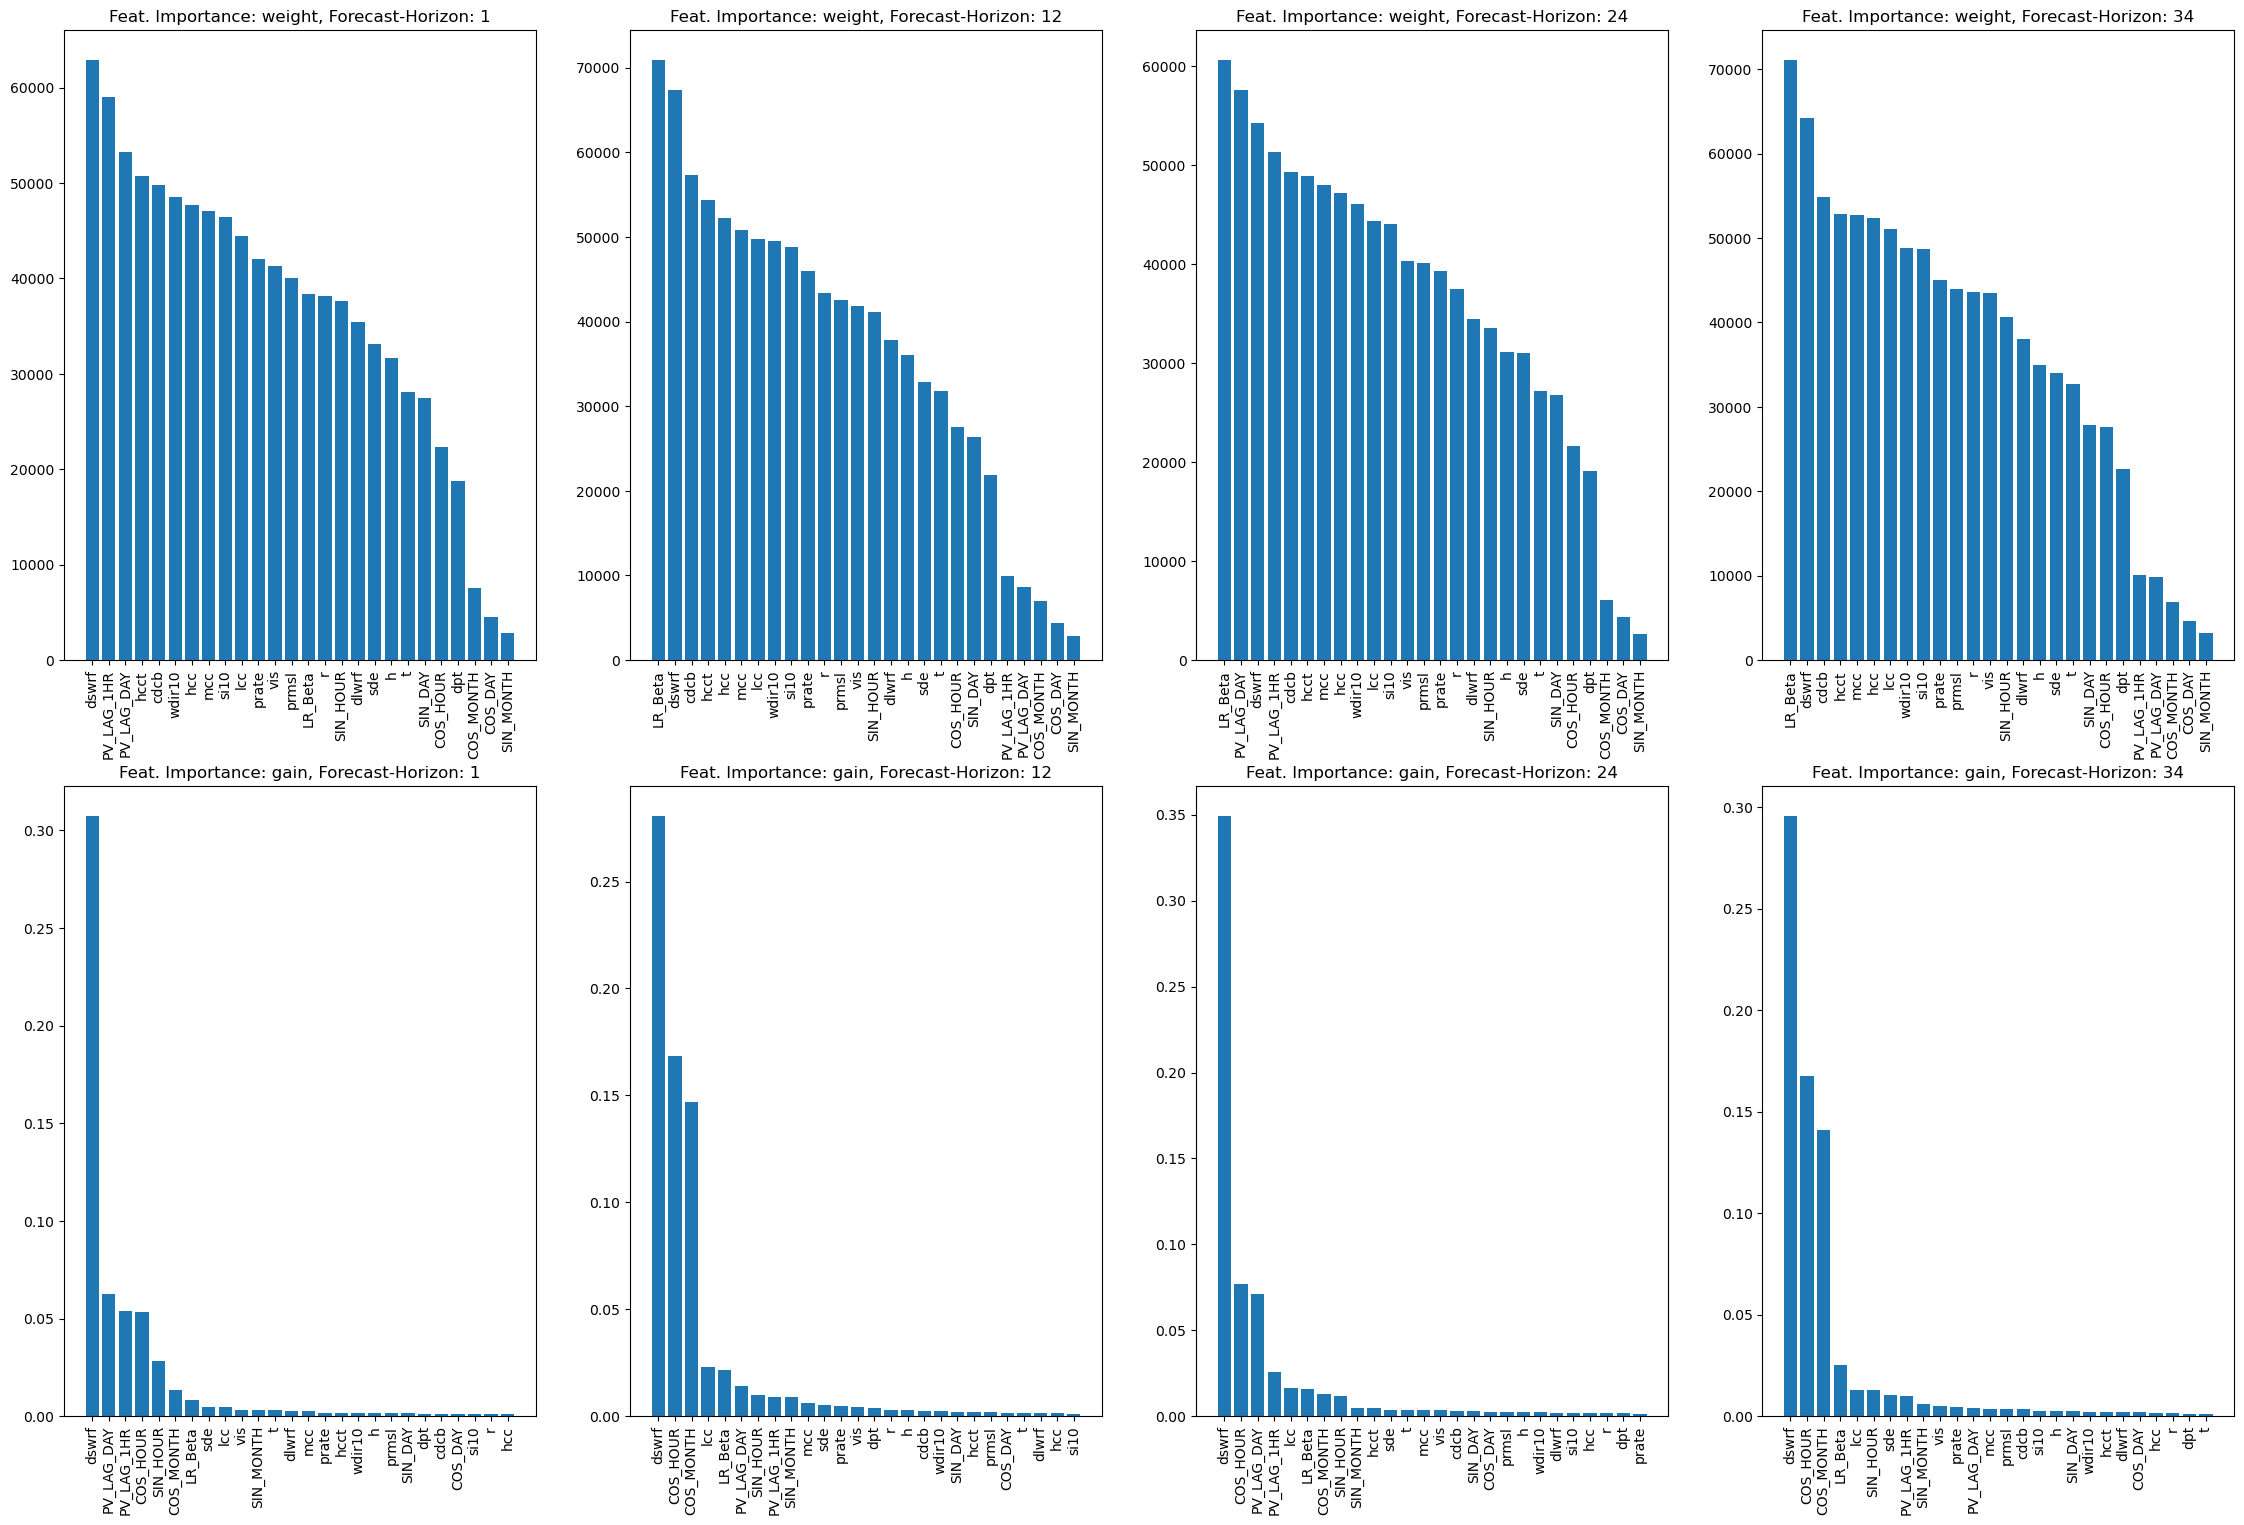

In [7]:
plot_feature_importances(results)

In [8]:
# Trying to understand why 24hours performs better than ~18 hours.
# Initial intution is that the NWP forecast for +24 hours is more accurate
# than +18, despite being further away, and this is reflected in the model.
from dataclasses import dataclass
from gradboost_pv.models.experiment import DEFFAULT_HYPARAM_CONFIG
from xgboost import XGBRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error

@dataclass
class ExperimentSummaryGroupInitTime:
    mse_train_loss: pd.Series
    mse_test_loss: pd.Series
    mae_train_loss: pd.Series
    mae_test_loss: pd.Series


def run_experiment_group_init_time_evaluation(
    X: pd.DataFrame,
    y: pd.DataFrame,
    booster_hyperparam_config: dict = DEFFAULT_HYPARAM_CONFIG
) -> ExperimentSummaryGroupInitTime:

    # use 2020 as training period and 2021 as test
    X_train, y_train = X.loc[X.index < "2021-01-01"], y.loc[y.index < "2021-01-01"]
    X_test, y_test = X.loc[X.index >= "2021-01-01"], y.loc[y.index >= "2021-01-01"]

    model = XGBRegressor(**booster_hyperparam_config)
    model.fit(X_train, y_train)
    
    # group the init_time by hour an evaluate the model at such points
    train_mse = X_train.groupby(X_train.index.hour).apply(lambda x: mean_squared_error(y.loc[x.index], model.predict(x)))
    test_mse = X_test.groupby(X_test.index.hour).apply(lambda x: mean_squared_error(y.loc[x.index], model.predict(x)))
    train_mae = X_train.groupby(X_train.index.hour).apply(lambda x: mean_absolute_error(y.loc[x.index], model.predict(x)))
    test_mae = X_test.groupby(X_test.index.hour).apply(lambda x: mean_absolute_error(y.loc[x.index], model.predict(x)))
    
    return ExperimentSummaryGroupInitTime(
        train_mse,
        test_mse,
        train_mae,
        test_mae
    )

In [15]:
results = dict()

for _step in range(0, 36):
    # can't really multiprocess this since the xgb training maxes out the cores anyway
    step_slice = load_local_preprocessed_slice(_step)
    step_slice = step_slice.reshape(step_slice.shape[1], step_slice.shape[2])
    X, y = build_datasets_from_local(step_slice, gsp, nwp.coords["step"].values[_step])
    output = run_experiment_group_init_time_evaluation(X, y)
    results[_step] = output
    print(f"Completed run for step {_step}")

Completed run for step 0
Completed run for step 1
Completed run for step 2
Completed run for step 3
Completed run for step 4
Completed run for step 5
Completed run for step 6
Completed run for step 7
Completed run for step 8
Completed run for step 9
Completed run for step 10
Completed run for step 11
Completed run for step 12
Completed run for step 13
Completed run for step 14
Completed run for step 15
Completed run for step 16
Completed run for step 17
Completed run for step 18
Completed run for step 19
Completed run for step 20
Completed run for step 21
Completed run for step 22
Completed run for step 23
Completed run for step 24
Completed run for step 25
Completed run for step 26
Completed run for step 27
Completed run for step 28
Completed run for step 29
Completed run for step 30
Completed run for step 31
Completed run for step 32
Completed run for step 33
Completed run for step 34
Completed run for step 35


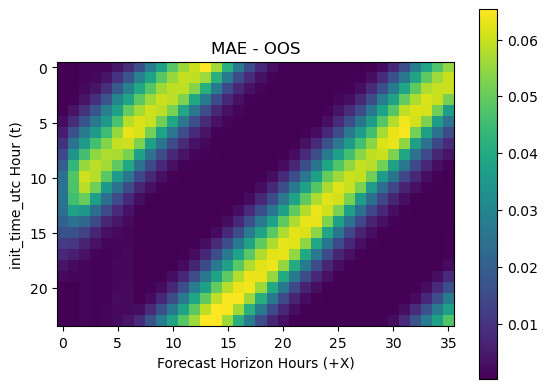

In [16]:
plt.imshow(pd.concat({fh: r.mae_test_loss for fh, r in results.items()}, axis=1))
plt.ylabel("init_time_utc Hour (t)")
plt.xlabel("Forecast Horizon Hours (+X)")
plt.title("MAE - OOS")
plt.colorbar()

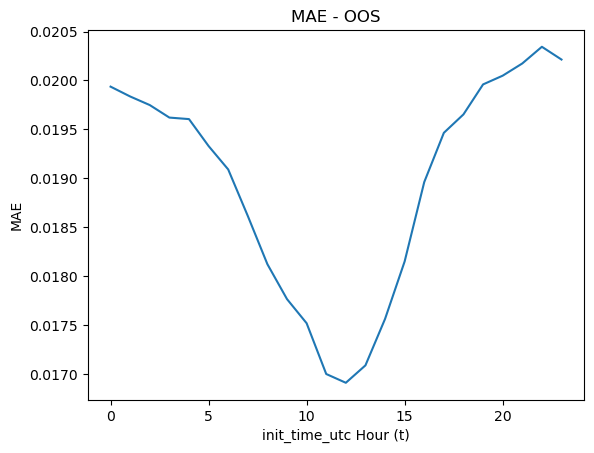

'\nThis makes sense - the primary source of variability in the errors occur at peak day time, therefore further you are from this point, the less your 1 hour lagged PV variable helps your forecast for the midday point\n'

In [18]:
# take forecast horizons in range(0, 24) as to not bias for more than one cycle
pd.concat({fh: r.mae_test_loss for fh, r in results.items()}, axis=1)[range(0, 24)].mean(axis=1).plot()
plt.title("MAE - OOS")
plt.ylabel("MAE")
plt.xlabel("init_time_utc Hour (t)")
plt.show()
"""
This makes sense - the primary source of variability in the errors occur at peak day time, therefore further you are from this point, the less your 1 hour lagged PV variable helps your forecast for the midday point
"""

Text(0.5, 0, 'Forecast Horizon Hours (+X)')

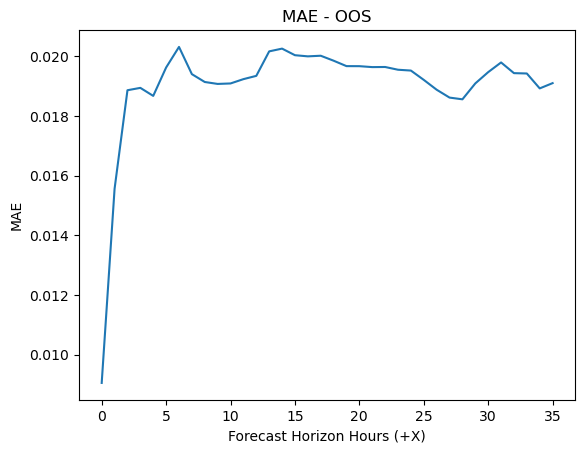

In [19]:
pd.concat({fh: r.mae_test_loss for fh, r in results.items()}, axis=1).mean(axis=0).plot()
plt.title("MAE - OOS")
plt.ylabel("MAE")
plt.xlabel("Forecast Horizon Hours (+X)")